数据流水线，模型，损失函数，小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集

In [2]:
def synthetic_data(w,b,num_examples):
    """生成 y = xw + b + 噪声"""
    x = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(x,w)
    y += torch.normal(0,0.01,y.shape)
    return x,y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

features中每一行都包含一个二维数据样本（特征矩阵），labels中的每一行都包含一维标签值(一个标量)

In [3]:
print('features:',features[0],'\nlabels:',labels[0])

features: tensor([-0.6182, -1.8185]) 
labels: tensor([4.9436])


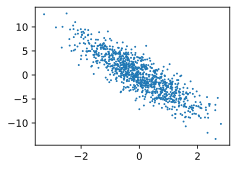

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),
                labels.detach().numpy(),1);

定义一个data_iter函数，该函数接收批量大小，特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [5]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #样本随机读取，没有特定顺序
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]
        
batch_size = 10

for x,y in data_iter(batch_size,features,labels):
    print(x,'\n',y)
    break

tensor([[ 1.4238, -0.0495],
        [-0.4070,  0.2368],
        [ 0.2932, -0.0368],
        [ 0.9317, -2.2593],
        [ 0.2538, -0.3742],
        [ 0.4142,  0.9925],
        [ 0.0757,  0.1344],
        [ 0.1698,  0.6759],
        [-1.6110,  0.5234],
        [ 1.6252, -0.7051]]) 
 tensor([[ 3.0222],
        [-1.6181],
        [ 0.7215],
        [ 9.5498],
        [ 1.7820],
        [-2.5299],
        [-0.2934],
        [-1.9394],
        [-5.0056],
        [ 5.6450]])


定义，初始化模型

In [6]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

定义模型

In [7]:
def linreg(x,w,b):
    """线性回归模型"""
    return torch.matmul(x,w) + b

定义损失函数

In [8]:
def squared_loss(y_hat,y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法

In [9]:
def sgd(params,lr,batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

**训练过程

In [10]:
lr = 0.001
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for x,y in data_iter(batch_size,features,labels):
        l = loss(net(x,w,b),y)  #'x'和'y'的小批量损失
        #因为'l'的形状是(batch_size,1)，而不是一个标量，'1'中所有元素均被加到
        #并以此计算[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)  #使用参数的梯度更新参数
    with torch.no_grad():
        train_1 = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1},loss {float(train_1.mean()):f}')

epoch 1,loss 6.526160
epoch 2,loss 5.299367
epoch 3,loss 4.303210


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [11]:
print(f'w的误差估计： {true_w - w.reshape(true_w.shape)}')
print(f'b的误差估计： {true_b - b}')

w的误差估计： tensor([ 1.4472, -2.4856], grad_fn=<SubBackward0>)
b的误差估计： tensor([4.2031], grad_fn=<RsubBackward1>)


线性回归的简单实现

In [12]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = d2l.synthetic_data(true_w,true_b,1000)

调用API接口读取数据

In [13]:
def load_array(data_arrays,batch_size,is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size = 10
data_iter = load_array((features,labels),batch_size)

next(iter(data_iter))

[tensor([[ 1.4310, -0.3728],
         [ 1.5889, -0.2819],
         [-1.1550,  0.7176],
         [-2.5022,  1.6232],
         [-1.5203,  1.8712],
         [ 1.0116, -0.7215],
         [ 0.5472, -0.4415],
         [-0.4623, -0.2321],
         [ 2.5820,  1.1457],
         [-0.6502,  0.2827]]),
 tensor([[ 8.3279],
         [ 8.3380],
         [-0.5548],
         [-6.3193],
         [-5.2020],
         [ 8.6730],
         [ 6.7963],
         [ 4.0731],
         [ 5.4727],
         [ 1.9528]])]

使用框架的预定义好的层

In [14]:
#'nn'是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2,1))

初始化模型参数

net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

计算均方误差使用的是MSELoss类，也称为平方范数

In [15]:
loss = nn.MSELoss()

实例化SGD实例

In [16]:
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

训练模块

In [17]:
num_epochs = 3
for epoch in range(num_epochs):
    for x,y in data_iter:
        l = loss(net(x),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    print(f'epoch {epoch+1},loss {l:f}')

epoch 1,loss 0.000325
epoch 2,loss 0.000101
epoch 3,loss 0.000101
